In [69]:
import os
import math
import numpy as np
import ffmpeg
import cv2
import imutils
from imutils.video import count_frames
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import sleep

In [3]:
ROOT_DIR = os.path.dirname(os.getcwd())
DATA_FOLDER = os.path.join(ROOT_DIR, "data")

In [4]:
video_L_path = os.path.join(DATA_FOLDER, "keparoicam_clipL_synchronized.mp4")
video_R_path = os.path.join(DATA_FOLDER, "keparoicam_clipR_synchronized.mp4")

In [5]:
video_left_capture = cv2.VideoCapture(video_L_path)
video_right_capture = cv2.VideoCapture(video_R_path)

In [6]:
left_n_frames = int(video_left_capture.get(cv2.CAP_PROP_FRAME_COUNT))
right_n_frames = int(video_right_capture.get(cv2.CAP_PROP_FRAME_COUNT))

print(left_n_frames)
print(right_n_frames)

total_frames = min(left_n_frames, right_n_frames)
print(total_frames)

left_width = int(video_left_capture.get(cv2.CAP_PROP_FRAME_WIDTH)) 
left_height = int(video_left_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
left_fps = video_left_capture.get(cv2.CAP_PROP_FPS)

right_width = int(video_right_capture.get(cv2.CAP_PROP_FRAME_WIDTH)) 
right_height = int(video_right_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
right_fps = video_right_capture.get(cv2.CAP_PROP_FPS)

print(left_width)
print(left_height)
print(left_fps)

print(right_width)
print(right_height)
print(right_fps)

10774
10763
10763
1920
1080
59.94005994005994
1920
1080
59.9365495637156


In [7]:
final_fps = 60.0
final_height = 1080
final_width = 1920
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')

In [8]:
video_path = os.path.join(DATA_FOLDER, "example_keparoiCam_of.avi")
video_output = cv2.VideoWriter(video_path, fourcc, final_fps, (final_width,final_height))

In [21]:
def equalize_histogram(rgb_image):
    r_image, g_image, b_image = cv2.split(rgb_image)

    r_image_eq = cv2.equalizeHist(r_image)
    g_image_eq = cv2.equalizeHist(g_image)
    b_image_eq = cv2.equalizeHist(b_image)

    image_eq = cv2.merge([r_image_eq, g_image_eq, b_image_eq])
    return image_eq

In [22]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def apply_clahe(image):
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    image_lab[...,0] = clahe.apply(image_lab[...,0])

    bgr_clahe_image = cv2.cvtColor(image_lab, cv2.COLOR_LAB2BGR)
    rgb_clahe_image = cv2.cvtColor(bgr_clahe_image, cv2.COLOR_BGR2RGB)

    return rgb_clahe_image

In [23]:
def preprocess_image(image, equalize_hist=True, clahe=False):
    if equalize_hist:
        image = equalize_histogram(image)
    if clahe:
        image = apply_clahe(image)
    
    return image

def preprocess_images(images):
    preprocessed_images = []
    
    for image in images:
        preprocessed_image = preprocess_image(image)
        preprocessed_images.append(preprocessed_image)
        
    return preprocessed_images

In [16]:
def calculate_optical_flow(frame, frame2):
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray1 = cv2.GaussianBlur(gray1, (21, 21), 0)
    
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.GaussianBlur(gray2, (21, 21), 0)

    frame_delta = cv2.absdiff(gray1, gray2)

    thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    ones = thresh == 255
    ones_flat = ones.flatten()

    optical_flow = np.sum(ones_flat)
    
    return optical_flow

def calculate_optical_flow_score_from_mask(mask):
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray_mask, 25, 255, cv2.THRESH_BINARY)[1]
    ones = gray_mask == 255
    ones_flat = ones.flatten()
    optical_flow_score = np.sum(ones_flat)
    
    return optical_flow_score

def calculate_dense_optical_flow(frame1, frame2):
    frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255
    
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY) if len(frame2.shape) == 3 else frame2
    flow = cv2.calcOpticalFlowFarneback(frame1_gray, frame2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    optical_flow_score = calculate_optical_flow_score_from_mask(bgr_flow)
    
    return optical_flow_score
    

def calculate_optical_flow_with_background(frame, background_frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.GaussianBlur(frame, (5, 5), 0)
    frame_delta = cv2.absdiff(frame, background_frame)

    thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]
    # thresh = cv2.dilate(thresh, None, iterations=2)
    
    ones = thresh == 255
    ones_flat = ones.flatten()

    optical_flow = np.sum(ones_flat)
    
    return optical_flow

def calculate_optical_flow_metric_with_background(frames, background_frame):
    n_frames = len(frames)
    n_frames_middle = int(math.floor(n_frames/2))
    
    total_optical_flow = 0
    
    for frame in frames[::5]:
        total_optical_flow += calculate_dense_optical_flow(frame, background_frame)
        
    return total_optical_flow

def calculate_optical_flow_metric(frames):
    n_frames = len(frames)
    n_frames_middle = int(math.floor(n_frames/2))
    
    total_optical_flow = 0
    
    #for frame1, frame2 in zip(frames[0:n_frames_middle], frames[n_frames_middle:n_frames]):
    #    total_optical_flow += calculate_optical_flow(frame1, frame2)
    
    prev = None
    this = None
    for frame in frames[::5]:
        if prev is None:
            prev = frame
            continue
            
        this = frame
        total_optical_flow += calculate_dense_optical_flow(this, prev)
        prev = this
        
    return total_optical_flow
    
    
def write_frames(output_handle, frames):
    for frame in frames:
        output_handle.write(frame)

In [209]:
def estimate_background(video_capture, n_frames=100, min_frame=0, max_frame=np.inf):
    
    random_frames = []
    
    if np.isinf(max_frame):
        max_frame = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
    
    frame_ids = [id for id in random.sample(range(min_frame, max_frame), n_frames)]
    
    for frame_id in frame_ids:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
        ret, frame = video_capture.read()
        random_frames.append(frame)

    random_frames_np = np.stack(random_frames)
    print(random_frames_np.shape)
    first_item = random_frames_np[0]
    print(first_item)
    print(first_item.shape)
    plt.imshow(first_item)
    plt.show()
    blues, greens, reds = random_frames_np[:,:,:,0], random_frames_np[:,:,:,1], random_frames_np[:,:,:,2]
    
    blues_median, greens_median, reds_median = np.mean(blues, axis=0), np.mean(greens, axis=0),  np.mean(reds, axis=0)
    
    print(blues_median)
    print(greens_median)
    print(reds_median)
    
    estimation = np.stack([reds_median, greens_median, blues_median], axis=2)
    
    print(estimation.shape)
    
    print(estimation)
    return estimation

In [210]:
def is_grayscale(frame: np.ndarray) -> bool:
    if len(frame.shape) < 3 or frame.shape[2]  == 1:
        return True
    return False
        
def farneback_optical_flow(frame1: np.ndarray, frame2: np.ndarray) -> np.ndarray:
    
    if not is_grayscale(frame1):
        frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    
    if not is_grayscale(frame2):
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        
    flow = cv2.calcOpticalFlowFarneback(
        frame1, frame2, None, 
        pyr_scale = 0.5, 
        levels = 5, 
        winsize = 15, 
        iterations = 5, 
        poly_n = 5, 
        poly_sigma = 1.2, 
        flags = 0
    )
        
    return flow
    
def visualize_farneback_optical_flow(flow, mask):
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    magnitude = np.nan_to_num(magnitude)
    angle = np.nan_to_num(angle)
    mask[..., 0] = angle * 180 / np.pi / 2
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    return rgb

def calculate_flow_metric(flow):
    gray_mask = cv2.cvtColor(flow, cv2.COLOR_BGR2GRAY)
    blurred_mask = cv2.GaussianBlur(gray_mask, (3, 3), 0)
    mask_sum = np.sum(blurred_mask)
    
    return mask_sum

(1, 1080, 1920, 3)
[[[159 144 147]
  [166 151 154]
  [208 193 196]
  ...
  [255 252 255]
  [255 252 255]
  [255 252 255]]

 [[162 147 150]
  [165 150 153]
  [205 190 193]
  ...
  [255 252 255]
  [255 252 255]
  [255 252 255]]

 [[174 159 162]
  [163 148 151]
  [195 180 183]
  ...
  [255 252 255]
  [255 252 255]
  [255 252 255]]

 ...

 [[ 96  68  73]
  [ 88  60  65]
  [ 81  53  58]
  ...
  [109 120 111]
  [ 98 109 100]
  [ 86  97  88]]

 [[ 90  62  67]
  [ 80  52  57]
  [ 67  39  44]
  ...
  [123 134 125]
  [108 119 110]
  [ 89 100  91]]

 [[ 84  56  61]
  [ 71  43  48]
  [ 56  28  33]
  ...
  [109 120 111]
  [109 120 111]
  [103 114 105]]]
(1080, 1920, 3)


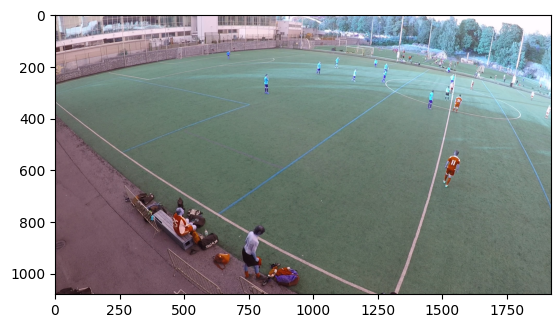

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[159. 166. 208. ... 255. 255. 255.]
 [162. 165. 205. ... 255. 255. 255.]
 [174. 163. 195. ... 255. 255. 255.]
 ...
 [ 96.  88.  81. ... 109.  98.  86.]
 [ 90.  80.  67. ... 123. 108.  89.]
 [ 84.  71.  56. ... 109. 109. 103.]]
[[144. 151. 193. ... 252. 252. 252.]
 [147. 150. 190. ... 252. 252. 252.]
 [159. 148. 180. ... 252. 252. 252.]
 ...
 [ 68.  60.  53. ... 120. 109.  97.]
 [ 62.  52.  39. ... 134. 119. 100.]
 [ 56.  43.  28. ... 120. 120. 114.]]
[[147. 154. 196. ... 255. 255. 255.]
 [150. 153. 193. ... 255. 255. 255.]
 [162. 151. 183. ... 255. 255. 255.]
 ...
 [ 73.  65.  58. ... 111. 100.  88.]
 [ 67.  57.  44. ... 125. 110.  91.]
 [ 61.  48.  33. ... 111. 111. 105.]]
(1080, 1920, 3)
[[[147. 144. 159.]
  [154. 151. 166.]
  [196. 193. 208.]
  ...
  [255. 252. 255.]
  [255. 252. 255.]
  [255. 252. 255.]]

 [[150. 147. 162.]
  [153. 150. 165.]
  [193. 190. 205.]
  ...
  [255. 252. 255.]
  [255. 252. 255.]
  [255. 252. 255.]]

 [[162. 159. 174.]
  [151. 148. 163.]
  [183. 180. 195.]

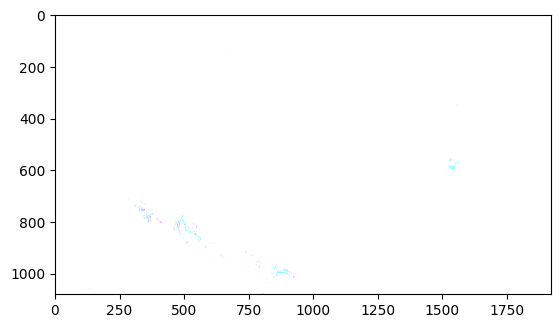

In [217]:
bg_estimate = estimate_background(video_left_capture, n_frames=1, min_frame=0, max_frame=30*10)
print(np.min(bg_estimate))
print(np.max(bg_estimate))
plt.imshow(bg_estimate)
plt.show()

In [63]:
video_left_capture.set(cv2.CAP_PROP_POS_FRAMES, -1)
video_right_capture.set(cv2.CAP_PROP_POS_FRAMES, -1)

_, first_left = video_left_capture.read()
_, first_right = video_right_capture.read()

prev_left = cv2.cvtColor(first_left, cv2.COLOR_BGR2GRAY)
prev_right = cv2.cvtColor(first_right, cv2.COLOR_BGR2GRAY)

mask = np.zeros_like(first_left)
mask[..., 1] = 255

for i in range(1000):
    
    video_left_capture.set(cv2.CAP_PROP_POS_FRAMES, 1+(i*30))
    video_right_capture.set(cv2.CAP_PROP_POS_FRAMES, 1+(i*2))
    
    res_left, frame_left = video_left_capture.read()
    res_right, frame_right = video_right_capture.read()

    gray_left = cv2.cvtColor(frame_left, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(frame_right, cv2.COLOR_BGR2GRAY)
    
    flow_left = farneback_optical_flow(prev_left, gray_left)
    flow_right = farneback_optical_flow(prev_right, gray_right)
    
    left_mask = visualize_farneback_optical_flow(flow_left, mask)
    right_mask = visualize_farneback_optical_flow(flow_right, mask)
    
    left_score = calculate_flow_metric(left_mask)
    right_score = calculate_flow_metric(right_mask)
    
    print(f"Left score: {left_score}")
    print(f"Right score: {right_score}")
    
    if left_score == 0 or right_score == 0:
        continue
    
    if left_score > right_score:
        print("Choose LEFT")
    else:
        print("Choose RIGHT")
    
    prev_left = gray_left
    prev_right = gray_right
    
    sleep(1)

Left score: 32533317
Right score: 2572
Choose LEFT
Left score: 10258403
Right score: 10151351
Choose LEFT
Left score: 16969314
Right score: 8245680
Choose LEFT
Left score: 23915955
Right score: 16653285
Choose LEFT
Left score: 39501062
Right score: 533
Choose LEFT
Left score: 7307963
Right score: 3753610
Choose LEFT
Left score: 6731706
Right score: 5950405
Choose LEFT
Left score: 13998375
Right score: 1826
Choose LEFT
Left score: 16564335
Right score: 4116
Choose LEFT
Left score: 79
Right score: 12961974
Choose RIGHT
Left score: 793
Right score: 7171470
Choose RIGHT
Left score: 941
Right score: 1751
Choose RIGHT
Left score: 12059717
Right score: 4116
Choose LEFT
Left score: 1428
Right score: 1582
Choose RIGHT
Left score: 343
Right score: 5484524
Choose RIGHT
Left score: 941
Right score: 8462928
Choose RIGHT
Left score: 611
Right score: 4911777
Choose RIGHT
Left score: 10402655
Right score: 6007814
Choose LEFT
Left score: 8417340
Right score: 4994
Choose LEFT


KeyboardInterrupt: 

In [ ]:
# Without background estimation

captured_frames = []

#optical_flow_window_length = int(math.floor(final_fps / 2))
#n_windows = math.floor(total_frames/optical_flow_window_length)

for i in tqdm(range(n_windows)):
    
    left_frames = []
    right_frames = []
    
    for j in range(optical_flow_window_length):
        frame_number = i*optical_flow_window_length + j
        video_left_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        res, frame = video_left_capture.read()
        if res:
            left_frames.append(frame)
        else:
            print("Error reading frame")
    
    for j in range(optical_flow_window_length):
        frame_number = i*optical_flow_window_length + j
        video_right_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        res, frame = video_right_capture.read()
        if res:
            right_frames.append(frame)
        else:
            print("Error reading frame")

    
    left_optical_flow = calculate_optical_flow_metric(left_frames)
    right_optical_flow = calculate_optical_flow_metric(right_frames)
    
    if left_optical_flow > right_optical_flow:
        images_processed = preprocess_images(left_frames)
    else:
        images_processed = preprocess_images(right_frames)

    write_frames(video_output, images_processed)

video_left_capture.release()
video_right_capture.release()
video_output.release()

In [ ]:
left_camera_background = estimate_background(video_left_capture)
right_camera_background = estimate_background(video_right_capture)

In [ ]:
# With background estimation

captured_frames = []

optical_flow_window_length = int(math.floor(final_fps / 2))
n_windows = math.floor(total_frames/optical_flow_window_length)

# left_camera_background = estimate_background(video_left_capture)
# right_camera_background = estimate_background(video_right_capture)


for i in tqdm(range(n_windows)):
    
    left_frames = []
    right_frames = []
    
    for j in range(optical_flow_window_length):
        frame_number = i*optical_flow_window_length + j
        video_left_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        res, frame = video_left_capture.read()
        if res:
            left_frames.append(frame)
        else:
            print("Error reading frame")
    
    for j in range(optical_flow_window_length):
        frame_number = i*optical_flow_window_length + j
        video_right_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        res, frame = video_right_capture.read()
        if res:
            right_frames.append(frame)
        else:
            print("Error reading frame")

    left_optical_flow = calculate_optical_flow_metric_with_background(left_frames, left_camera_background)
    right_optical_flow = calculate_optical_flow_metric_with_background(right_frames, right_camera_background)
    
    if left_optical_flow > right_optical_flow:
        # images_processed = preprocess_images(left_frames)
        images_processed = left_frames
    else:
        # images_processed = preprocess_images(right_frames)
        images_processed = right_frames
        
    write_frames(video_output, images_processed)

video_left_capture.release()
video_right_capture.release()
video_output.release()

In [ ]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())


def calculate_humans_from_frames(frames):
    n_of_humans = 0
    
    for frame in frames[::5]:
        # frame = cv2.resize(frame, (640, 480))
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        boxes, weights = hog.detectMultiScale(gray, winStride=(8,8) )
        
        #boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])
        #for (xA, yA, xB, yB) in boxes:
        #    cv2.rectangle(frame, (xA, yA), (xB, yB),(0, 255, 0), 2)
        
        n_of_humans += len(boxes)
        
    return n_of_humans
    

In [ ]:
# With human detection

captured_frames = []

optical_flow_window_length = int(math.floor(final_fps / 2))
n_windows = math.floor(total_frames/optical_flow_window_length)

# left_camera_background = estimate_background(video_left_capture)
# right_camera_background = estimate_background(video_right_capture)

prev = None

for i in tqdm(range(n_windows)):
    
    left_frames = []
    right_frames = []
    
    for j in range(optical_flow_window_length):
        frame_number = i*optical_flow_window_length + j
        video_left_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        res, frame = video_left_capture.read()
        if res:
            left_frames.append(frame)
        else:
            print("Error reading frame")
    
    for j in range(optical_flow_window_length):
        frame_number = i*optical_flow_window_length + j
        video_right_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        res, frame = video_right_capture.read()
        if res:
            right_frames.append(frame)
        else:
            print("Error reading frame")

    left_n_of_humans = calculate_humans_from_frames(left_frames)
    right_n_of_humans = calculate_humans_from_frames(right_frames)
    
    if left_n_of_humans == right_n_of_humans:
        if prev == 'left':
            left_n_of_humans += 1
        else:
            right_n_of_humans += 1
    
    if left_n_of_humans > right_n_of_humans:
        images_processed = preprocess_images(left_frames)
        prev = "left"
    else:
        images_processed = preprocess_images(right_frames)
        prev = "right"

    write_frames(video_output, images_processed)

video_left_capture.release()
video_right_capture.release()
video_output.release()
